# Wheat coleoptile response to transient inclination

Comparison between the result from a thearitical model and the data obtained from experiments on wheat coleoptiles. 
The model is computed by the callculevolution function.

### Load python modules

In [13]:
%matplotlib inline
from pylab import *
import pandas as pd
from scipy import integrate
from matplotlib import pyplot as plt

data_folder = './data/Figure5/'

## Define the model function

In [14]:
#=========================================================================
#Computation of the equations describing the model

def calculevolution(Ainit,tincl,tauaval,tauretard,taudose,beta,L,DLdt, tfin=250):

    R=0.8 #Plant radius
    dt=0.2 #in minute
    
    ntfin=int(tfin/dt)
    ntincl=int(tincl/dt)
    nstep=500 #Number of point on the curvilinear axes (along the stem)
    ds=L/nstep
    ntretard=int(tauretard/dt)

    ntsortie=1  #how many time we record the output 
    
    doteps = DLdt / L
    
    Bdt=dt*doteps/R*beta


    #=========================================================================
    #Init data tables in memory
    
    Ainit=Ainit*pi/180.0
    Atot=zeros((ntfin+1,nstep+1))
    Astatotot=zeros((ntfin+1,nstep+1))
    Ctot=zeros((ntfin+1,nstep+1))
    Sdosetot=zeros((ntfin+1,nstep+1))
    Pdosetot=Sdosetot=zeros((ntfin+1,nstep+1))
    Xtot=zeros((ntfin+1,nstep+1))
    Ytot=zeros((ntfin+1,nstep+1))

    Atige=ones(nstep+1)*Ainit
    Astato=zeros(nstep+1)
    Sdose=zeros(nstep+1)
    Pdose=zeros(nstep+1)
    Astatoretard=zeros((ntretard+1,nstep+1))
    Cretard=zeros((ntretard+1,nstep+1))
    C=zeros(nstep+1)
    Abas=zeros(ntfin+1)
    Abas[0:ntincl]=Ainit*ones(ntincl)
    
    
    #=========================================================================
    #Compute the 4 differential equation of the model 
    integra = integrate.cumtrapz
    for it in range(ntfin+1):
        Atigeold=Atige[:]
        Atige=r_[Abas[it],Abas[it]+ds*integra(C)]
        dAstato=-dt/tauaval*sin(Astato-Atige)
        #dAstato=Astato-Atige
        dSdose=-dt/taudose*(Sdose-sin(Astatoretard[0]))
        dPdose=-dt/taudose*(Pdose-Cretard[0])
        dC=-Bdt*Sdose
        Astato=Astato+dAstato
        Sdose=Sdose+dSdose
        Pdose=Pdose+dPdose
        C=C+dC
        Astatoretard[0:-1,:]=Astatoretard[1:,:]
        Astatoretard[-1,:]=Astato
        Cretard[0:-1,:]=Cretard[1:,:]
        Cretard[-1,:]=C
        
        if it%ntsortie==0:
            Atot[it,:]=Atige-Ainit*(it<=ntincl-1)
            Astatotot[it,:]=Astato
            Ctot[it,:]=C
            Sdosetot[it,:]=Sdose
            dX=ds*sin(Atige)
            dY=ds*cos(Atige)
            X=r_[0,integra(dX)]
            Y=r_[0,integra(dY)]
            Xtot[it,:]=X;
            Ytot[it,:]=Y;
            
    ttot=dt*arange(ntfin+1)
    #end for =========================================================================
    return [ttot,Atot*180.0/pi,Astatotot*180.0/pi,Sdosetot,Xtot,Ytot]

#Compute the maximum slope of the curve
def maxdepente(X):
    dt = 0.2
    dXdt=diff(X)/dt
    return max(dXdt)

# Load data

### Permanent stimulus 

In [15]:
#Tvar_A for the angle
#Tvar_L for the length
#Tvar_TT for the time
data2 = pd.read_csv( data_folder+'permanent_stimulus_curves_1g.txt', sep='\t' )

#Compute the mean angle curve for permanent stimulus
moyAperm=(data2['Tvar_A23'][:70]+data2['Tvar_A24'][:70]+data2['Tvar_A26'][:70]+data2['Tvar_A27'][:70])/4.
tperm=data2['Tvar_TT27'][:70]

#Data of gravitropic sensitivity for permanent stimulus from chauvet et al. 2016 Scientific reports
Bble=0.7
Bble_std = 0.17

### Transient stimulus

In [16]:
#Tip angle time evolution for 1g for 
data1g_courbes = pd.read_hdf(data_folder+'transient_mean_curves_1g.hdf','data')

#Response for 1g and 3g
data3g = pd.read_csv(data_folder+'gravitropic_response_3g.csv', index_col=0)
data1g = pd.read_csv(data_folder+'gravitropic_response_1g.csv', index_col=0)

s1 = data3g[ data3g.sequence == 1 ]
pix2cmgravi = 132/2.5 #scale from pixel to cm in 3g experiments
DL=0.197 #scale from pixel to cm in 1g permanent experiments
DLDTmoy = mean( (s1['DLDT_moy_(pixel/min)'].mean()/pix2cmgravi *10**1, data1g['dldt_pix/min'].mean()*DL ) )
Rmoy = s1['Rayon_(pixel)'].mean()/pix2cmgravi*10**1

#  Model for transient stimulus

### Constants for wheat coleoptiles

In [17]:
R = 0.8 #Shoot radius 
Ainit = -45.0 #Angle of inclination during the transient stimulus 
tauaval = 1.04 #Avalanche time scale
taureaction = 13.0 #Reaction time scale
taumemory = 13.0 #Memory time scale
beta=0.8 #Gravitropic sensitivity
L=20.0 #Shoot size
DLdt=0.0167 #Shoot growth rate

### Run the model for severals $\Delta t$

In [18]:
nimax=50
reponse=zeros(nimax)

for i in range (nimax):
    tincl=float(i)
    [ttot,Atot,Astatotot,Sdosetot,Xtot,Ytot]=calculevolution(Ainit,tincl,tauaval,taureaction,taumemory,beta,L,DLdt)
    AA=array(Atot[:,-1])
    dAdt=maxdepente(AA)
    reponse[i]=dAdt/180.0*pi*R/DLdt/sin(-Ainit/180.0*pi)
treponse=arange(nimax)


### Run the model to get time evolution of the tip angle for some $\Delta t$

In [19]:
[ttot,Atot3,Astatotot3,Sdosetot,Xtot,Ytot]=calculevolution(Ainit,3.,tauaval,taureaction,taumemory,beta,L,DLdt)
[ttot,Atot8,Astatotot8,Sdosetot,Xtot,Ytot]=calculevolution(Ainit,8.,tauaval,taureaction,taumemory,beta,L,DLdt)
[ttot,Atot11,Astatotot11,Sdosetot,Xtot,Ytot]=calculevolution(Ainit,11.,tauaval,taureaction,taumemory,beta,L,DLdt)
[ttot,Atot20,Astatotot20,Sdosetot,Xtot,Ytot]=calculevolution(Ainit,20.,tauaval,taureaction,taumemory,beta,L,DLdt)
[ttot,Atotperm,Astatototperm,Sdosetot,Xtot,Ytot]=calculevolution(Ainit,250.,tauaval,taureaction,taumemory,beta,L,DLdt)
dAdt3=maxdepente(Atot3[:,-1])
reponse3=Rmoy/DLDTmoy*dAdt3
dAdt8=maxdepente(Atot8[:,-1])
reponse8=Rmoy/DLDTmoy*dAdt8
dAdt11=maxdepente(Atot11[:,-1])
dAdt20=maxdepente(Atot20[:,-1])


## Plot the data and the result from the theoritical model

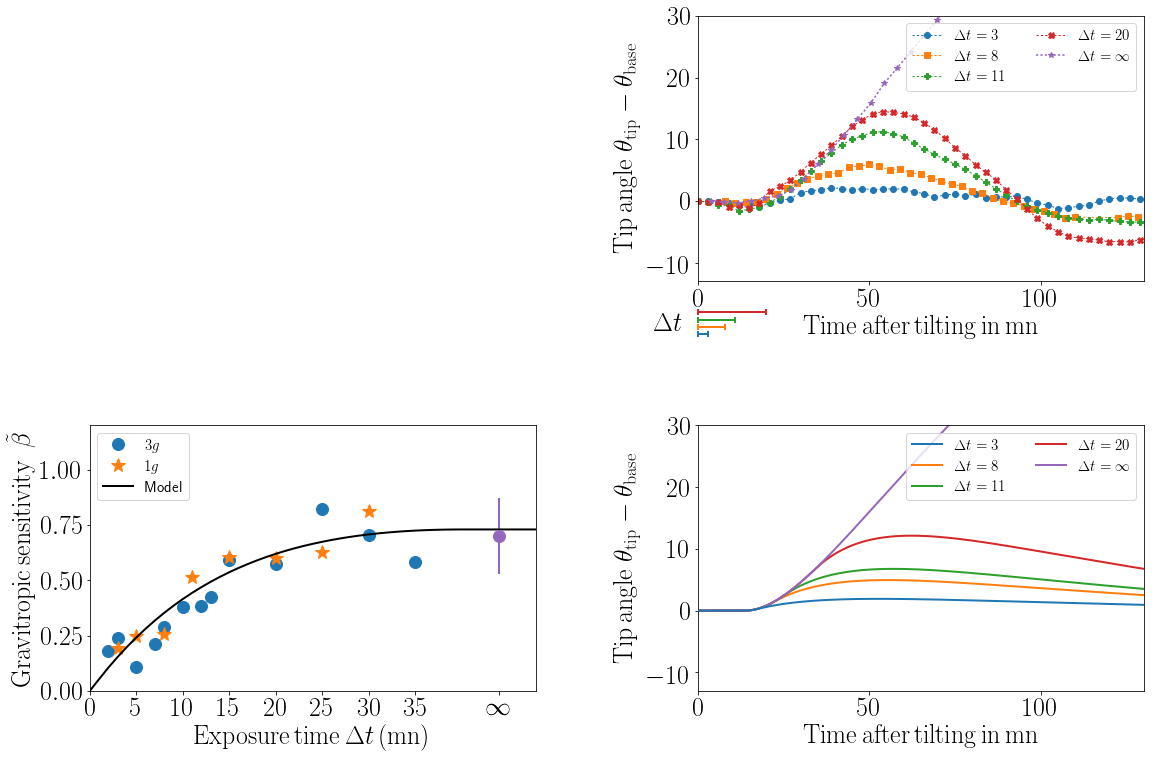

In [20]:
mpl.rcParams['font.size'] = 26
mpl.rcParams['text.usetex'] =True
mpl.rcParams['figure.figsize']=[9,4]

G= GridSpec(2,2)
figure(figsize=(9*2,2.5*5))
subplot(G[0,1])

markers = ['o','s','P','X']
cptm = 0
for dt in data1g_courbes:
    #print dt
    if dt in [3,8,11,20]:
        plot(data1g_courbes[dt]['temps'], 
             -(data1g_courbes[dt]['angles']-data1g_courbes[dt]['angles'][0]),"%s:"%markers[cptm],
             label=r'$\Delta t = %i$'%dt,
            linewidth=1)
        
        cptm += 1
        
plot(tperm*22/17,moyAperm-moyAperm[0],"*:",label=r'$\Delta t = \infty$')      



legend(loc='upper right',ncol=2, fontsize=15)
xlim(0,130)
ylim(-13,30)
xlabel(r'$\rm{Time\, after\, tilting\, in\, min}$')
ylabel(r'$\rm{Tip\, angle}\; \theta_{tip} - \theta_{base}$')

init = -18
delta = -1.2
xinit = 0
plot([xinit,20+xinit],[init]*2,'C3-|', clip_on=False, lw=2, markeredgewidth=2, zorder=100)
plot([xinit,11+xinit],[init+delta]*2,'C2-|', clip_on=False, lw=2, markeredgewidth=2, zorder=100)
plot([xinit,8+xinit],[init+delta*2]*2,'C1-|', clip_on=False, lw=2, markeredgewidth=2, zorder=100)
plot([xinit,3+xinit],[init+delta*3]*2,'C0-|', clip_on=False, lw=2, markeredgewidth=2, zorder=100)
text(-13, init+2.5*delta, r'$\Delta t$', rotation=0)

subplot(G[1,1])

plot(ttot,Atot3[:,-1],label=r'$\Delta t = 3$',lw=2,zorder=100)
plot(ttot,Atot8[:,-1],label=r'$\Delta t = 8$',lw=2)    
plot(ttot,Atot11[:,-1],label=r'$\Delta t = 11$',lw=2) 
plot(ttot,Atot20[:,-1],label=r'$\Delta t = 20$',lw=2) 
plot(ttot,Atotperm[:,-1],label=r'$\Delta t = \infty$',lw=2)       


legend(loc='upper right',ncol=2, fontsize=15)
xlim(0,130)
ylim(-13,30)
xlabel(r'$\rm{Time\, after\, tilting\, in\, min}$')
ylabel(r'$\rm{Tip\, angle}\; \theta_{tip} - \theta_{base}$')

subplot(G[1,0])
s1 = data3g[ data3g.sequence == 1 ]
s1m = s1.groupby(s1['temps_expo_(min)']).mean()
expo = s1['temps_expo_(min)'].unique()


plot(s1m.index,  1/sin(deg2rad(45)) *  Rmoy * deg2rad(s1m['DADT_moy_(deg/min)'])/DLDTmoy, 'C0o', ms=12, label="$3g$")
plot(data1g.expo,  1/sin(deg2rad(45)) * Rmoy * deg2rad(data1g['dadt_(deg/min)'])/DLDTmoy, 'C1*', ms=14, label="$1g$")
errorbar(44, Bble, yerr=Bble_std, clip_on=False, fmt='C4o', lw=2, ms=12)

ylim(0,1.2)
ylabel(r'$\mathrm{Gravitropic\, sensitivity}$\, $\tilde{\beta}$',ma='center')
xlabel(r'$\mathrm{Exposure\, time}\, \Delta t \, \mathrm{(min)}$ ')

plot(treponse,reponse,'-k',lw=2, label='Model')

legend(loc='upper left', frameon=True, numpoints=1, 
       fontsize=15)

xticks([0,5,10,15,20,25,30,35,44], ['$0$','$5$','$10$','$15$','$20$','$25$','$30$','$35$',r'$\infty$'])
xlim(0,48)

tight_layout(pad=3)